In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import sys
import numpy as np
import glob
import torch

sys.path.insert(1,"/home/showalte/research/prob_seq_queries/")
from seq_queries.utils import read_pkl, write_pkl

In [60]:
def get_experiment_data(experiment, dataset, h, s, root="../data", 
            methods=['beam_search_is_hybrid','importance_sampling'],
            gt_methods=['ground_truth','beam_search']):
    
        data_dict = {}
        gt_type=None
        for method in methods:
            template_path=root + f"/{method}/{dataset}/{experiment}/"
            template_file=f"{experiment.replace('_','-')}_{dataset.replace('_','-')}_{method.replace('_','-')}_{h}h_{s}s*.pkl"
            pot_pattern = os.path.join(template_path,template_file)
            pot_paths = glob.glob(pot_pattern)
            assert len(pot_paths) == 1,\
                f"Found {len(pot_paths)} paths for {pot_pattern}"
            data_dict[method]= read_pkl(pot_paths[0])
            data_dict[method]['metadata']['result_filepath'] = pot_paths[0]
        for gt_method in gt_methods:
            try:
                template_path=root + f"/{gt_method}/{dataset}/{experiment}/"
                template_file=f"{experiment.replace('_','-')}_{dataset.replace('_','-')}_{gt_method.replace('_','-')}_{h}h_{s}s*.pkl"
                pot_pattern = os.path.join(template_path,template_file)
                pot_paths = glob.glob(pot_pattern)
                assert len(pot_paths) == 1,\
                    f"Found {len(pot_paths)} paths for {pot_pattern}"
                print(pot_paths[0])
                data_dict[gt_method]= read_pkl(pot_paths[0])
                data_dict[gt_method]['metadata']['result_filepath'] = pot_paths[0]
                data_dict['gt_type'] = gt_method
                return data_dict
            except: pass
        assert False,"Could not find ground truth"
        return None
                
            
    



# Estimate fields
- ground_truth/beam_search_lb
- Importance sampling estimate
- Hybrid estimate
- Importance sampling variance
- Hybrid variance

# General Metadata
- dataset_name
- experiment_name
- history_id
- Excluded term
- sequence_length
- history_length
- total_sequence_length

# Sampling metadata
- num_mc_samples (sub_estimates)
- sample_model_iters

# Hybrid data
- hybrid_model_iters

# Beam search metadata
- min_variance
- search_model_iters
- min_variance_reduction
- true_coverage
- restricted_coverage
- num_beams
- top_k
- top_p
- (beam search) interpolation_func


In [84]:
# def flatten_hybrid_sampling(samp_dict,sub_estimates,sample_type="importance"):
#     samp_estimates = samp_dict['hybrid_bs_is_estimate'][:,:len(sub_estimates)]
#     if not sub_estimates:
#         if len(samp_estimates.shape) ==3:
#             assert samp_estimates.shape[1] == samp_dict['metadata']['num_mc_samples'],\
#             (f"Error, estimate dimensions are {samp_estimates.shape} but the number of samples is" +
#              f"{samp_dict['metadata']['num_mc_samples']}, which does not match")
            
#             samp_estimates = torch.gather(samp_estimates.mean(dim=1),1,
#                                           samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
#             assert len(samp_estimates.shape) == 1,f"Shape of imp_samp_estimates is {len(samp_estimates.shape)}"
#         if len(samp_estimates.shape) ==2:
#             samp_estimates = torch.gather(samp_estimates,1,
#                                               samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
        
#         df = pd.DataFrame(samp_estimates)
#         df.insert(0,'num_mc_samples',samp_dict['metadata']['num_mc_samples'])
#         df[f'{sample_type}_model_iters'] = samp_dict['model_iters']
#         df[f'{sample_type}_est_variance'] = samp_dist['hyrbid_var']
        
#     else:
#         assert samp_estimates.shape[1] == len(sub_estimates),\
#         ("Importance sampling estimates and sub_estimates are not aligned in shape." +
#          f"got sample_est: {samp_estimates.shape[1]} and sub_estimates: {len(sub_estimates)}")
#         print(samp_estimates.shape)
#         if len(samp_estimates.shape) == 2:
#             samp_estimates = pd.DataFrame(samp_estimates,columns=sub_estimates)
#             samp_var = pd.DataFrame(samp_dict['hybrid_var'][:,:len(sub_estimates)],columns=sub_estimates)
#             model_iters_df = pd.DataFrame(samp_dict['model_iters'][:,:len(sub_estimates)],columns=sub_estimates)
#             df = pd.melt(samp_estimates,value_vars=sub_estimates)
#             df.columns = ['num_samples','sample_estimate']
#             print(df.head())
#             var_df =  pd.melt(samp_var,value_vars=sub_estimates)
#             var_df.columns = ['num_samples','variance']
#             iter_df = pd.melt(model_iters_df,value_vars=sub_estimates)
#             iter_df.columns = ['num_samples','model_iters']
#             df[f'{sample_type}_model_iters']=iter_df['model_iters']
#             df[f'{sample_type}_est_variance']=var_df['variance']
#             print("length 2")
#             print(df.shape)
            
#         elif len(samp_estimates.shape) == 3:
#             df_list = []
#             for i in range(len(sub_estimates)):
#                 df = pd.DataFrame(
#                             torch.gather(samp_estimates[:,i],1,
#                                       samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
#                         )
#                 df.insert(0,'num_mc_samples',sub_estimates[i])
#                 df[f'{sample_type}_model_iters'] = samp_dict['model_iters'][:,i]
#                 df[f'{sample_type}_est_variance'] = samp_dict['sample_est_var'][:,i]
#                 print(df.shape)
#                 df_list.append(df)
            
#             df = pd.concat(df_list,axis=0,ignore_index=True)
#         else:
#             assert False,f"Shape of samp_estimates is {len(samp_estimates.shape)}"
#     assert df.shape[-1] == 4, f"DF shape is {df.shape}"
#     df.columns = ['num_mc_samples',f'{sample_type}_sampling_est',
#                   f'{sample_type}_model_iters',f'{sample_type}_est_variance']
    
#     return df


def flatten_sampling(samp_dict,sub_estimates,sample_type="importance"):
    print(samp_dict.keys())
    samp_estimates = samp_dict['sample_estimates'][:,:len(sub_estimates)]
    print(samp_dict['excluded_terms'].shape)
    if not sub_estimates:
        if len(samp_estimates.shape) ==3:
            assert samp_estimates.shape[1] == samp_dict['metadata']['num_mc_samples'],\
            (f"Error, estimate dimensions are {samp_estimates.shape} but the number of samples is" +
             f"{samp_dict['metadata']['num_mc_samples']}, which does not match")
            
            samp_estimates = torch.gather(samp_estimates.mean(dim=1),1,
                                          samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
            assert len(samp_estimates.shape) == 1,f"Shape of imp_samp_estimates is {len(samp_estimates.shape)}"
        if len(samp_estimates.shape) ==2:
            samp_estimates = torch.gather(samp_estimates,1,
                                              samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
        
        df = pd.DataFrame(samp_estimates)
        df.insert(0,'num_mc_samples',samp_dict['metadata']['num_mc_samples'])
        df[f'{sample_type}_model_iters'] = samp_dict['model_iters']
        df[f'{sample_type}_est_variance'] = samp_dist['sample_estimate_var']
        
    else:
        assert samp_estimates.shape[1] == len(sub_estimates),\
        ("Importance sampling estimates and sub_estimates are not aligned in shape." +
         f"got sample_est: {samp_estimates.shape[1]} and sub_estimates: {len(sub_estimates)}")
        if len(samp_estimates.shape) == 2:
            samp_estimates = pd.DataFrame(samp_estimates,columns=sub_estimates)
            samp_var = pd.DataFrame(samp_dict['sample_estimate_var'][:,:len(sub_estimates)],columns=sub_estimates)
            model_iters_df = pd.DataFrame(samp_dict['model_iters'][:,:len(sub_estimates)],columns=sub_estimates)
            df = pd.melt(samp_estimates,value_vars=sub_estimates)
            df.columns = ['num_samples','sample_estimate']
            var_df =  pd.melt(samp_var,value_vars=sub_estimates)
            var_df.columns = ['num_samples','variance']
            iter_df = pd.melt(model_iters_df,value_vars=sub_estimates)
            iter_df.columns = ['num_samples','model_iters']
            df[f'{sample_type}_model_iters']=iter_df['model_iters']
            df[f'{sample_type}_est_variance']=var_df['variance']
            
        elif len(samp_estimates.shape) == 3:
            df_list = []
            for i in range(len(sub_estimates)):
                df = pd.DataFrame(
                            torch.gather(samp_estimates[:,i],1,
                                      samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
                        )
                df.insert(0,'num_mc_samples',sub_estimates[i])
                df[f'{sample_type}_model_iters'] = samp_dict['model_iters'][:,i]
                samp_est_var = torch.gather(samp_dict['sample_estimate_var'][:,i],1,
                                            samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
                                            
                df[f'{sample_type}_est_variance'] = samp_est_var
                df_list.append(df)
            df = pd.concat(df_list,axis=0,ignore_index=True)
        else:
            assert False,f"Shape of samp_estimates is {len(samp_estimates.shape)}"
    assert df.shape[-1] == 4, f"DF shape is {df.shape}"
    df.columns = ['num_mc_samples',f'{sample_type}_sampling_est',
                  f'{sample_type}_model_iters',f'{sample_type}_est_variance']
    
    return df



def flatten_gt(data_dict,gt_type):
    gt_dict = data_dict[gt_type]
    # gt = gt_dict['bs_lower_bound']
    gt = torch.gather(gt_dict['bs_lower_bound'],1,
                      gt_dict['excluded_terms'].unsqueeze(-1)).squeeze()
    assert len(gt.shape) == 1,\
    f"Ground truth has {len(gt.shape)} dimensions"
    df = pd.DataFrame(gt,columns=['ground_truth'])
    for item in ['true_coverage','restricted_coverage']:
        df[item] = [gti.item() for gti in gt_dict[item]]
    # df["gt_model_iters"] = gt_dict['model_iters']
    df['gt_type'] = gt_type
    
    return df
    

def flatten_experiment(data_dict,experiment, dataset,h,s,
     global_agreement_vals= ['excluded_terms']):
    sub_estimates = sorted(list(
        set(data_dict['importance_sampling']['metadata']['sub_estimates']) &
        set(data_dict['beam_search_is_hybrid']['metadata']['sub_estimates'])))
    sub_est_len = 1 if not sub_estimates else len(sub_estimates)
    importance_df = flatten_sampling(data_dict['importance_sampling'],sub_estimates,sample_type ='importance')
    hybrid_df = flatten_sampling(data_dict['beam_search_is_hybrid'],sub_estimates,sample_type ='hybrid')
    hybrid_df.drop("num_mc_samples",inplace = True,axis=1)
    gt_df = flatten_gt(data_dict,data_dict['gt_type'])
    gt_df = pd.concat([gt_df]*sub_est_len,axis=0,ignore_index=True)
    final_df = pd.concat([importance_df,hybrid_df,gt_df],axis=1)
    # print(hybrid_df.head())
    # print(importance_df.head())
    # print(final_df.isnull().sum())
    
    # Metadata checks
    is_metadata = ['top_k','top_p']
    bs_metadata = ['min_variance','min_var_reduction','num_beams']
    for m in is_metadata:
        final_df[m] = data_dict['importance_sampling']['metadata'][m]
    for m in bs_metadata:
        final_df[m] = data_dict[data_dict['gt_type']]['metadata'][m]
    final_df['interp_func'] = str(data_dict[data_dict['gt_type']]['metadata']['interp_func']).split(" ")[1]
    
    
    final_df['dataset_name'] = dataset
    final_df['hist_len'] = h
    final_df['total_seq_len'] = s
    final_df['seq_len'] = s-h
    sequence_ids = list(range(data_dict['importance_sampling']['sample_estimates'].shape[0]))*sub_est_len
    excluded_terms = data_dict['importance_sampling']['excluded_terms'].numpy().tolist()*sub_est_len
    final_df['sequence_id'] = sequence_ids
    final_df['excluded_term'] = excluded_terms
    
    return final_df
     
    
    

In [85]:
experiment = ["val_dl"]
dataset = ["apps"]
lengths = [(13,15),(12,15)]
def flatten_experiments(experiments, datasets, lengths):
    data_list = []
    for experiment in experiments:
        for dataset in datasets:
            for h,s in lengths:
                # try:
                    
                    data = get_experiment_data(experiment,dataset,h,s)
                    df = flatten_experiment(data,experiment, dataset, h,s)
                    # print(df.head())
                    # print(df.columns)
                    # print(df.shape)
                    # sys.exit(1)
                    data_list.append(df)
                # except Exception as e:
                #     print("Could not flatten: Experiment: {} | Dataset: {} | lengths: {}"\
                #           .format(experiment, dataset, (h,s)))
                    
    # print(len(data_list))
    data_df = pd.concat(data_list,axis = 0)
    ordering = [ 'dataset_name','sequence_id','seq_len', 'excluded_term', 'gt_type','ground_truth','importance_sampling_est','hybrid_sampling_est', 
                'num_mc_samples', 'importance_model_iters','hybrid_model_iters',
       'importance_est_variance',  'hybrid_est_variance',
         'true_coverage', 'restricted_coverage',  'top_k', 'top_p', 'min_variance',
       'min_var_reduction', 'num_beams', 'interp_func',
       'hist_len', 'total_seq_len', ]
    data_df = data_df[ordering]
    print(data_df.columns)
    
    return data_df
                
                          

In [95]:
df = flatten_experiments(['val_dl'],['amazon'],[(13,15)])
# df = flatten_experiments(['val_dl'],['shakespeare'],[(18,20)])

../data/ground_truth/amazon/val_dl/val-dl_amazon_ground-truth_13h_15s.pkl
dict_keys(['sample_estimates', 'sample_estimate_var', 'sample_estimate_mean', 'model_iters', 'metadata', 'excluded_terms'])
torch.Size([6384])
dict_keys(['bs_lower_bound', 'is_estimates', 'sample_estimates', 'model_iters', 'sample_estimate_var', 'sample_estimate_mean', 'num_beams', 'metadata', 'excluded_terms'])
torch.Size([6384])
Index(['dataset_name', 'sequence_id', 'seq_len', 'excluded_term', 'gt_type',
       'ground_truth', 'importance_sampling_est', 'hybrid_sampling_est',
       'num_mc_samples', 'importance_model_iters', 'hybrid_model_iters',
       'importance_est_variance', 'hybrid_est_variance', 'true_coverage',
       'restricted_coverage', 'top_k', 'top_p', 'min_variance',
       'min_var_reduction', 'num_beams', 'interp_func', 'hist_len',
       'total_seq_len'],
      dtype='object')


In [87]:
# data['importance_sampling']['metadata']['sub_estimates']
print(df.shape)
print(df.isnull().sum())

(6861, 23)
dataset_name               0
sequence_id                0
seq_len                    0
excluded_term              0
gt_type                    0
ground_truth               0
importance_sampling_est    0
hybrid_sampling_est        0
num_mc_samples             0
importance_model_iters     0
hybrid_model_iters         0
importance_est_variance    0
hybrid_est_variance        0
true_coverage              0
restricted_coverage        0
top_k                      0
top_p                      0
min_variance               0
min_var_reduction          0
num_beams                  0
interp_func                0
hist_len                   0
total_seq_len              0
dtype: int64


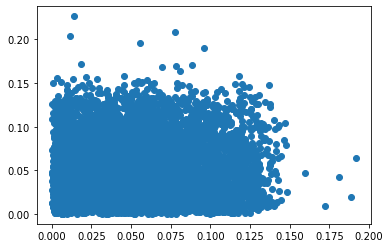

In [98]:
plt.scatter(df.loc[df['num_mc_samples'] == 10,'ground_truth'],df.loc[df['num_mc_samples'] == 10,'hybrid_sampling_est'])

In [92]:
df[['hybrid_model_iters','importance_model_iters']].describe()

,hybrid_model_iters,importance_model_iters
count,6861.000000,6861.000000
mean,222.262061,7400.000000
std,332.629628,8940.450221
min,20.000000,200.000000
25%,20.000000,200.000000
50%,22.000000,2000.000000
75%,328.000000,20000.000000
max,1834.000000,20000.000000


In [99]:
# df.to_csv('padhraic_shakespeare_17-18_20.csv',index=None)
df.to_csv('padhraic_amazon_13_15.csv',index=None)
# df.to_csv('padhraic_apps_12-13_15.csv',index=None)